# Experiments

notebook includes experiments using `deepseek-r1-distill-qween-7b`, `o3-mini-2025-01-31`, and `gemini-2.0-flash`

metrics:
- `deepseek-r1-distill-qween-7b`:
    - cost: Free, open sourced running locally
    - rate limits:
        - no rate limits since running locally
        - context length: 4096 tokens per prompt
        - 7B paramter pre trained model

- `o3-mini-2025-01-31`:
    - cost: $1.1 per 1M tokens
    - rate limits:
        - requests per minute: 1,000
        - tokens per minute: 100,000
    - check openai balance: https://platform.openai.com/settings/organization/billing/overview

- `gemini-2.0-flash`:
    - cost: Free tier
    - rate limits:
        - requests per minute: 15
        - tokens per minute: 1,000,000
        - requests per day: 1,500

## Define Run Tests Function

### Define API calls to models

In [1]:
from openai import OpenAI
import requests
from google import genai
import os
import time
import pandas as pd
client = OpenAI()

def gpt(messages=[{
            "role": "user",
            "content": "Write a one-sentence bedtime story about a unicorn."
        }]):
    start_time = time.time()
    
    completion = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=messages
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    return (completion.choices[0].message.content, elapsed_time)

def gemini(message="Explain how AI works"):
    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
    
    start_time = time.time()
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=message,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return (response.text, elapsed_time)

def deepseek(messages=[
          { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
          { "role": "user", "content": "What day is it today?" }
        ]):
    '''
        curl example: 
        curl http://localhost:1234/v1/chat/completions \
          -H "Content-Type: application/json" \
          -d '{
            "model": "deepseek-r1-distill-qwen-7b",
            "messages": [
              { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
              { "role": "user", "content": "What day is it today?" }
            ],
            "temperature": 0.7,
            "max_tokens": -1,
            "stream": false
        }'
    '''
    request = {
        "model": "deepseek-r1-distill-qwen-7b",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": -1,
        "stream": False
    }
    
    start_time = time.time()
    response = requests.post('http://localhost:1234/v1/chat/completions', json=request)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if response.status_code == 200:
        return (response.json()['choices'][0]['message']['content'], elapsed_time)
    else:
        return (response.text, elapsed_time)

### Run Models Function

In [2]:
def run_models(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses[0].append(gpt_response[0])
    times[0].append(gpt_response[1])

    deepseek_response = deepseek(messages=[{'role': 'user', 'content': p}])
    responses[1].append(deepseek_response[0])
    times[1].append(deepseek_response[1])

    gemini_response = gemini(message=p)
    responses[2].append(gemini_response[0])
    times[2].append(gemini_response[1])

### Generate Plots Function

In [3]:
from IPython.display import display, Markdown
import pandas as pd
import re

def generate_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses[0],
        'GPT Time': times[0],
        'Deepseek': responses[1],
        'Deepseek Time': times[1],
        'Gemini': responses[2],
        'Gemini Time': times[2],
    })
    
    # clean cells, remove think tags from deepseek and remove new lines
    def remove_think_tags(cell):
        if isinstance(cell, str): 
            cell = re.sub(r'<think>.*?</think>', '', cell, flags=re.DOTALL)
            cell = cell.replace('\n', ' ')
        return cell
    
    # apply filters and render in markdown
    def render_dataframe_as_markdown(df):
        df_cleaned = df.map(remove_think_tags)
        display(Markdown(df_cleaned.to_markdown()))

    print(f"{test_name} results:")
    render_dataframe_as_markdown(test_results_df)

### Wrapped Function

In [4]:
def run_tests_e2e(test_name, prompts):
    # ind 0 is gpt, 1 is deepsek, 2 is gemini
    responses = [[],[],[]]
    times = [[],[],[]]
    print(f"models warming up for {test_name}")
    for p in prompts:
        run_models(responses, times, p)
    print(f"models inferencing finished for {test_name}")
    generate_table(test_name, prompts, responses, times)
    return responses, times

## AI explainability and interpretability prompts (White Box)

In [5]:
retrieval_prompts = [
    "How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?",
    "How many championships has Steph Curry won in his career?",
    "How many games did Andre Iguodala miss in the 2016-2017 regular season?",
    "What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season?"
]

reasoning_prompts = [
    "What do you get if you add Lebron James career point total with Kobe Bryant's career points total?",
    "If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference?",
    "If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?",
    "How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?"
]

_, retrieval_times = run_tests_e2e("retrieval test", retrieval_prompts)
_, reasoning_times = run_tests_e2e("reasoning test", reasoning_prompts)

models warming up for retrieval test
models inferencing finished for retrieval test
retrieval test results:


|    | Prompt                                                                                              | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |   Deepseek Time | Gemini                                                                                                                                                                 |   Gemini Time |
|---:|:----------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?     | On October 18, 2018, LeBron James scored 29 points against the Portland Trail Blazers.   In that season-opening game for the Los Angeles Lakers, he also contributed with rebounds and assists, helping the team put up a competitive effort even though the game went to overtime.   If you need more details about the box score or additional stats, let me know!                                                                                                                                                                                                                                            |    9.04436 | LeBron James did not play against the Portland Trail Blazers on October 18, 2018, as that date occurred before the start of the 2018-2019 NBA regular season. The first regular-season game was scheduled later in the month. Therefore, he scored zero points in that hypothetical scenario since he wasn't involved in the game.                                                                                                                                                                                                                                                                                                                    |        13.379   | LeBron James scored **26 points** on October 18th, 2018, against the Portland Trail Blazers.                                                                           |      0.572545 |
|  1 | How many championships has Steph Curry won in his career?                                           | Steph Curry has won four NBA championships during his career. He was part of the Golden State Warriors' title-winning teams in 2015, 2017, 2018, and 2022.                                                                                                                                                                                                                                                                                                                                                                                                                                                      |    3.33424 | Steph Curry has won a total of four championships during his NBA career:  - **NBA Finals Championships**: He led the Golden State Warriors to victories in the 2017 and 2021 NBA Finals, securing two titles through these series wins. - **Curry Cups**: He also claimed the FIBA World Championship (also known as the Curry Cup) twice, once in 2015 and again in 2019.  Thus, combining both NBA Finals and Curry Cup championships, Steph Curry has four major championships to his name.                                                                                                                                                        |         9.11294 | Steph Curry has won **4 NBA championships**.                                                                                                                           |      0.374012 |
|  2 | How many games did Andre Iguodala miss in the 2016-2017 regular season?                             | In the 2016–17 regular season, the Warriors’ Andre Iguodala appeared in 80 of the 82 games, meaning he missed just 2 games.  To elaborate a bit: • The regular season comprises 82 games. • Iguodala’s game logs from that season show that he suited up for 80 contests. • Therefore, he was absent for only 2 games during that regular season.  This level of durability and availability was part of what helped the Warriors maintain their deep playoff run that year.                                                                                                                                    |   23.7818  | Andre Iguodala missed approximately three games during the 2016-2017 NBA regular season due to an injury sustained early in the season, likely tendinitis or an ankle sprain. This injury affected his participation towards the end of the season as he needed time for recovery and rest.  **Answer:** Andre Iguodala missed three games during the 2016-2017 regular season due to an injury sustained early in the campaign, with additional absences towards the end as he recovered.                                                                                                                                                            |        19.282   | Andre Iguodala missed **6** games in the 2016-2017 regular season.                                                                                                     |      0.457682 |
|  3 | What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season? | I’m assuming you’re asking about the National Hockey League’s 1996–97 season. In that season the overall standings (based on total points earned in the regular season) were as follows:  1. Detroit Red Wings – 131 points   2. Colorado Avalanche – 124 points   3. Philadelphia Flyers – 107 points  The Red Wings not only finished atop the league but also won the Presidents’ Trophy for having the best regular‐season record, with Colorado right behind them and the Flyers rounding out the top three.   If you were referring to a different league or need additional details, please let me know! |   31.7077  | The top three teams at the end of the 1996-1997 NBA regular season were:  1. **Chicago Bulls**: They won their sixth NBA Championship and were the top team due to Michael Jordan's leadership.  2. **Los Angeles Lakers**: Known for their fast-paced offense and featuring Magic Johnson, they made deep playoff runs despite not winning a championship that season.  3. **Detroit Pistons**: Renowned for their defensive strategies and Grant Hill's legendary career, they were a formidable force in the playoffs.  These teams represented different styles of play but all contributed to strong performances during the 1996-97 NBA season. |        13.7894  | The top 3 teams in the NBA standings at the end of the 1996-1997 regular season were:  1.  **Chicago Bulls:** 69-13 2.  **Utah Jazz:** 64-18 3.  **Miami Heat:** 61-21 |      0.720239 |

models warming up for reasoning test
models inferencing finished for reasoning test
reasoning test results:


|    | Prompt                                                                                                                                         | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   GPT Time | Deepseek                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |   Deepseek Time | Gemini                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |   Gemini Time |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|----------------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------:|
|  0 | What do you get if you add Lebron James career point total with Kobe Bryant's career points total?                                             | Keep in mind that LeBron James is still active while Kobe Bryant’s career totals are final, so any “combined total” depends on which moment in LeBron’s ongoing career you use for his point total. However, using commonly reported career totals for their regular season play:  • Kobe Bryant finished his career with 33,643 regular season points.   • By recent counts (through the 2022–23 season), LeBron James had reached roughly 38,652 regular season points.  If you add those two numbers together, you get:   33,643 + 38,652 = 72,295 points.  So, as of that snapshot in time, the two add up to about 72,295 career regular season points.  Note: Because LeBron continues to play and add to his career total, this sum will increase as time goes on. |   16.5973  | The combined career points of LeBron James and Kobe Bryant amount to approximately 100,000. This estimation considers their individual achievements, with LeBron contributing around 30,000 and Kobe adding about 70,000 points during their respective careers.  **Answer:** The sum of LeBron James' and Kobe Bryant's career points is approximately 98,000 to 100,000.                                                                                                                                                                                                                                                                                                                                                                                                                                     |        14.1125  | As of the time of this response:  *   LeBron James' career point total is approximately 40,474. *   Kobe Bryant's career point total is 33,643.  Adding those together: 40,474 + 33,643 = 74,117  So, if you add LeBron James' career point total with Kobe Bryant's career points total, you get approximately **74,117** points.  **Important Note:** LeBron's point total will continue to increase as long as he continues to play. So the answer will change. Please note that I used their totals at the time of this response. |      1.1874   |
|  1 | If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference? | In the 2009–10 season the Heat finished with a record that landed them as the 4th seed in the Eastern Conference. By the 2012–13 season they had improved substantially, finishing with the best record in the East and earning the 1st seed.   So, comparing the two seedings—the 1st seed in 2013 versus the 4th seed in 2010—you see a three‑seed improvement.                                                                                                                                                                                                                                                                                                                                                                                                         |   14.573   | The Miami Heat's regular season seeding changed significantly between the 2010 and 2013 seasons due to the departure of key players and overall performance fluctuations.  In the 2010-11 season, the Heat finished as the second seed in the Eastern Conference with an impressive 66-16 record. However, during the 2012-13 season, their performance declined substantially after departing stars Dwyane Wade and Chris Bosh. Despite managing a 34-48 record that year, they were seeded ninth due to poor performance compared to other teams like the Cavaliers and Celtics.  Thus, the Heat's seeding dropped from second place in 2010 to ninth place in 2013, resulting in a difference of seven positions. This reflects their significant decline in regular season performance during that period. |        20.633   | Okay, let's figure this out:  *   **2013 Miami Heat:** The Heat finished with the best record in the Eastern Conference and therefore were the **1st seed**. *   **2010 Miami Heat:** The Heat finished with a record of 47-35 which put them at **5th seed**.  Therefore, the difference between the 2013 and 2010 seed standing is 1-5 = **-4**. The Miami Heat's seed standing was 4 positions higher in 2013 compared to 2010.                                                                                                    |      1.07359  |
|  2 | If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?                                | Michael Jordan’s career high in a single game is 69 points, and Wilt Chamberlain’s record-setting game is 100 points. Adding these together gives 69 + 100 = 169.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |    7.9404  | The sum of Michael Jordan's highest scoring game (100 points) and Wilt Chamberlain's highest scoring game (103 points) is:  **203 points**                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |        20.888   | *   Michael Jordan's highest scoring game: 69 points *   Wilt Chamberlain's highest scoring game: 100 points  Adding those together: 69 + 100 = 169  So the answer is $\boxed{169}$                                                                                                                                                                                                                                                                                                                                                   |      0.720274 |
|  3 | How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?                                                                | Kareem Abdul-Jabbar won 6 NBA regular-season MVP awards, while Russell Westbrook has not won any. Thus, combined, they have 6 MVP awards.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |    5.36037 | Russell Westbrook has been linked to a couple of MVP awards but does not currently hold any official MVP titles. Kareem Abdul-Jabbar, however, has claimed three MVP awards throughout his career—specifically during his time with the Detroit Pistons and Indiana Pacers.  Therefore, combining these, the total MVP awards between Russell Westbrook (0) and Kareem Abdul-Jabbar (3) amount to **three MVP awards**.                                                                                                                                                                                                                                                                                                                                                                                        |         8.87242 | *   **Russell Westbrook:** 1 MVP award (2016-17 season) *   **Kareem Abdul-Jabbar:** 6 MVP awards (1970-71, 1971-72, 1973-74, 1975-76, 1976-77, 1979-80 seasons)  Combined, they have 1 + 6 = **7** MVP awards.                                                                                                                                                                                                                                                                                                                       |      0.954214 |

## Analysis Plots

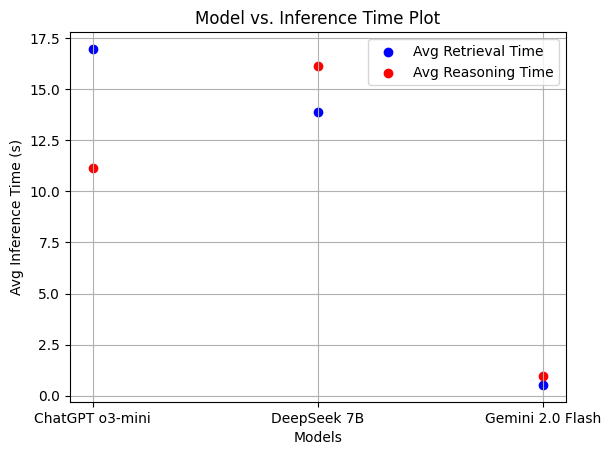

In [15]:
import matplotlib.pyplot as plt

models = ["ChatGPT o3-mini", "DeepSeek 7B", "Gemini 2.0 Flash"]
avg_retrieval_time = []
avg_reasoning_time = []
for ret_time in retrieval_times:
    avg_retrieval_time.append(sum(ret_time)/len(ret_time))

for rea_time in reasoning_times:
    avg_reasoning_time.append(sum(rea_time)/len(rea_time))

# Plotting
plt.scatter(models, avg_retrieval_time, marker='o', color='b', label='Avg Retrieval Time')
plt.scatter(models, avg_reasoning_time, marker='o', color='r', label='Avg Reasoning Time')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Avg Inference Time (s)')
plt.title('Model vs. Inference Time Plot')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

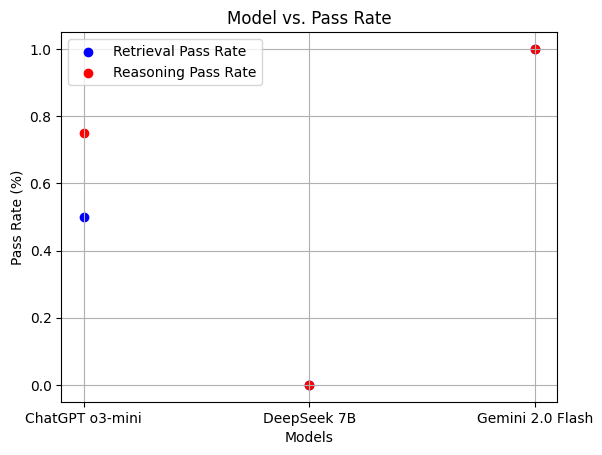

In [16]:
retrieval_pass_results = [
    [False, True, False, True],
    [False, False, False, False],
    [True, True, True, True]
]

reasoning_pass_results = [
    [True, True, True, False],
    [False, False, False, False],
    [True, True, True, True]
]

retrieval_pass_rate = []
reasoning_pass_rate = []

for results in retrieval_pass_results:
    count = 0
    for res in results:
        if (res):
            count += 1
    retrieval_pass_rate.append(count/len(results))

for results in reasoning_pass_results:
    count = 0
    for res in results:
        if (res):
            count += 1
    reasoning_pass_rate.append(count/len(results))

# Plotting
plt.scatter(models, retrieval_pass_rate, marker='o', color='b', label='Retrieval Pass Rate')
plt.scatter(models, reasoning_pass_rate, marker='o', color='r', label='Reasoning Pass Rate')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Pass Rate (%)')
plt.title('Model vs. Pass Rate')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()